# Choosing a neural network for forecastings

Researching to choose a LSTM a RNN or GRU

Data from: https://www.cryptodatadownload.com/data/binance/

In [ ]:
#https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/
#https://medium.com/swlh/stock-price-prediction-with-pytorch-37f52ae84632
#https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

In [33]:
import numpy as np
import pandas as pd
import datetime

In [34]:
data = pd.read_csv('Binance_BTCUSDT_1h.csv', header=1)
kill_am = lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %I-%p')
data['Date'] = data['Date'].apply(kill_am)
data.head()

Date   Symbol      Open  ...     Close  Volume BTC  Volume USDT
0 2020-08-14 22:00:00  BTCUSDT  11761.80  ...  11771.93     1574.82  18511548.54
1 2020-08-14 21:00:00  BTCUSDT  11762.04  ...  11761.80     1658.38  19471891.50
2 2020-08-14 20:00:00  BTCUSDT  11801.94  ...  11762.04     1941.45  22869349.57
3 2020-08-14 19:00:00  BTCUSDT  11823.24  ...  11801.94     2019.25  23836092.04
4 2020-08-14 18:00:00  BTCUSDT  11787.66  ...  11823.24     2323.34  27446101.75

[5 rows x 8 columns]

In [35]:
data.tail()

Date   Symbol      Open  ...    Close  Volume BTC  Volume USDT
26246 2017-08-17 08:00:00  BTCUSDT   4349.99  ...  4360.69      0.9499      4139.70
26247 2017-08-17 07:00:00  BTCUSDT   4324.35  ...  4349.99      4.4400     19241.06
26248 2017-08-17 06:00:00  BTCUSDT   4315.32  ...  4324.35      7.2300     31282.31
26249 2017-08-17 05:00:00  BTCUSDT   4308.83  ...  4315.32     23.2300    100304.82
26250 2017-08-17 04:00:00  BTCUSDT  16199.91  ...  4308.83     44.5100    190952.85

[5 rows x 8 columns]

In [36]:
data.dtypes

Date           datetime64[ns]
Symbol                 object
Open                  float64
High                  float64
Low                   float64
Close                 float64
Volume BTC            float64
Volume USDT           float64
dtype: object

In [37]:
len(data)

26251

In [38]:
my_coin = data.copy()

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=my_coin['Date'], y=my_coin['Open'],
                    mode='lines',
                    name='Open'))
fig.add_trace(go.Scatter(x=my_coin['Date'], y=my_coin['High'],
                    mode='lines',
                    name='High'))
fig.add_trace(go.Scatter(x=my_coin['Date'], y=my_coin['Low'],
                    mode='lines',
                    name='Low'))
fig.add_trace(go.Scatter(x=my_coin['Date'], y=my_coin['Close'],
                    mode='lines',
                    name='Close'))

#fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(title="BTC by hours, price in USDT")


## LSTM (Long Short Term Memory) a kind of RNN (Recurrent Neural Network)

A good explanation
https://medium.com/deep-math-machine-learning-ai/chapter-10-1-deepnlp-lstm-long-short-term-memory-networks-with-math-21477f8e4235

### Preparing data

In [44]:
# ► Normalize data

from sklearn.preprocessing import MinMaxScaler

high = data[['High']][::1]

high.head()

High
0  11798.05
1  11780.27
2  11825.36
3  11825.09
4  11833.34

In [45]:
scaler = MinMaxScaler(feature_range=(-1,1))
high['High'] = scaler.fit_transform(high['High'].values.reshape(-1,1))

In [46]:
def split_data(stock, lookback):
    
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [47]:
lookback = 60 # choose sequence length
x_train, y_train, x_test, y_test = split_data(high, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (20953, 59, 1)
y_train.shape =  (20953, 1)
x_test.shape =  (5238, 59, 1)
y_test.shape =  (5238, 1)


### Network structure

In [48]:
import torch
import torch.nn as nn

In [49]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [50]:
# Parameters

input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 40

In [51]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [52]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [53]:
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.2811882793903351
Epoch  1 MSE:  0.17155833542346954
Epoch  2 MSE:  0.09449189156293869
Epoch  3 MSE:  0.06942138075828552
Epoch  4 MSE:  0.09108161181211472
Epoch  5 MSE:  0.06374239921569824
Epoch  6 MSE:  0.05889146402478218
Epoch  7 MSE:  0.0639750063419342
Epoch  8 MSE:  0.06631679087877274
Epoch  9 MSE:  0.06294701248407364
Epoch  10 MSE:  0.055002689361572266
Epoch  11 MSE:  0.045562904328107834
Epoch  12 MSE:  0.04002648591995239
Epoch  13 MSE:  0.043092865496873856
Epoch  14 MSE:  0.03893689066171646
Epoch  15 MSE:  0.023470478132367134
Epoch  16 MSE:  0.017703156918287277
Epoch  17 MSE:  0.01383232232183218
Epoch  18 MSE:  0.010550477541983128
Epoch  19 MSE:  0.014314379543066025
Epoch  20 MSE:  0.008457585237920284
Epoch  21 MSE:  0.00597668532282114
Epoch  22 MSE:  0.0039244103245437145
Epoch  23 MSE:  0.004346639849245548
Epoch  24 MSE:  0.005445295479148626
Epoch  25 MSE:  0.005951546132564545
Epoch  26 MSE:  0.006108120083808899
Epoch  27 MSE:  0.00564780

In [54]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

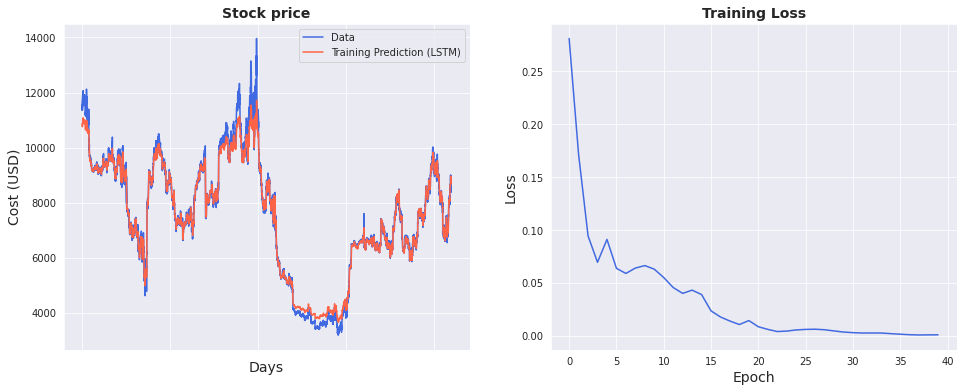

In [55]:
#import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [56]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 241.56 RMSE
Test Score: 1469.02 RMSE


In [57]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(high)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(high)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(high)-1, :] = y_test_pred

original = scaler.inverse_transform(high['High'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [58]:
fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LSTM)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()